In [1]:
#%matplotlib notebook  
from matplotlib import pyplot as plt
import numpy as np
import pasttrec_ctrl as ptc
import json
import sigproc_kit
import tdc_daq as td
import baseline_calib
import ROOT
import db
from cw_pasttrec_functions import *

from my_utils import *
set_width_max_of_jupyterpad()

    
def hist_rms(x,y):
  counts = np.sum(y)
  weights = y / counts
  mean = np.dot(x,weights)
  deviations = x - mean
  return np.sqrt(np.dot(deviations**2,weights))
def list_rms(x):
  mean = sum(x)/len(x)
  deviations = x - mean
  return np.sqrt(sum(deviations**2) /len(x))
def MeanArrays(xs,ys):
    return np.dot(xs,ys)/sum(ys)
def fwhm(x,y):
  dummy, t1, tot = sigproc_kit.discriminate(x,y,np.max(y)/2.,0,0)
  return tot

Welcome to JupyROOT 6.14/04


 parallel baseline scan board,  4000
switch on pulser, do threshold scan


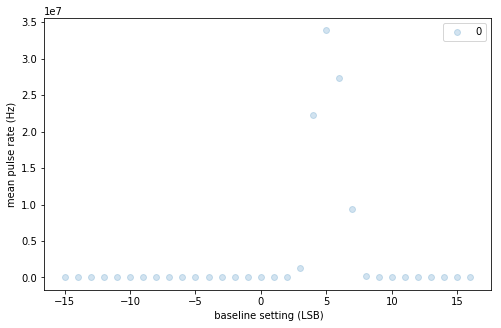

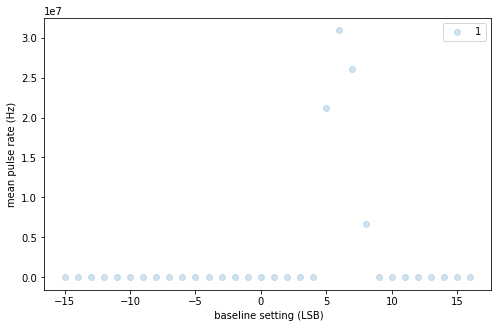

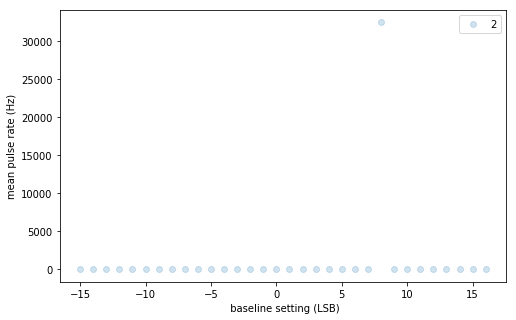

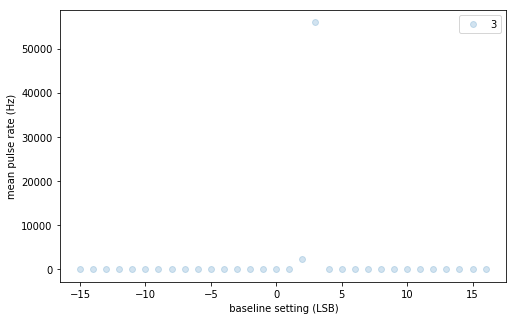

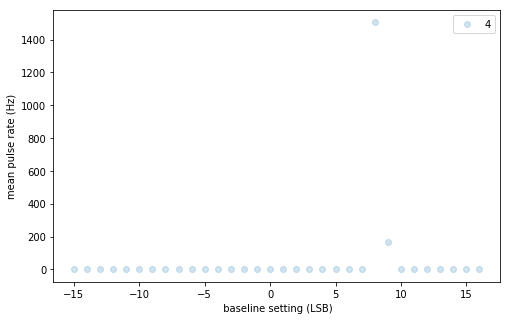

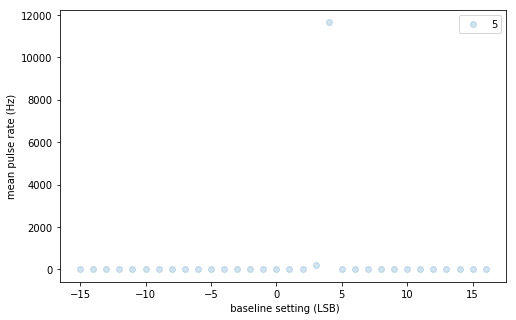

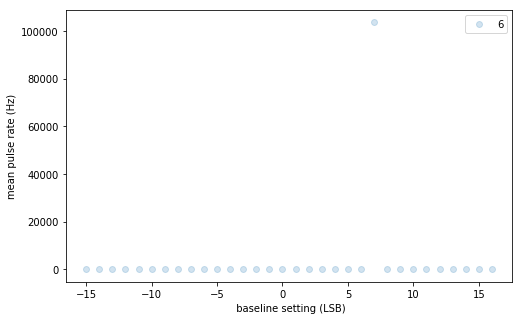

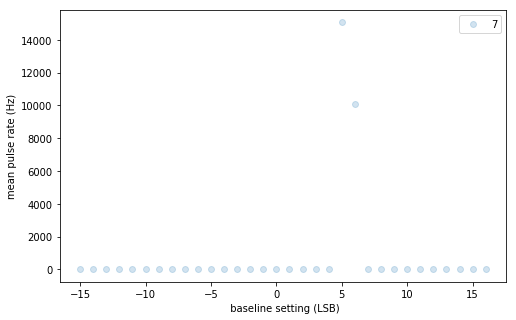

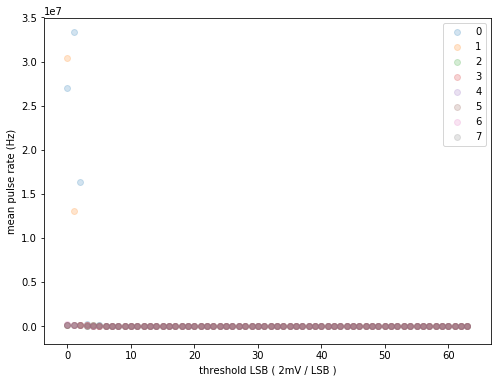

In [8]:
names=[ "4000"]
for name in names:
    ptc.init_active_boards()  

    print(" parallel baseline scan board, ", name)
    #baseline_calib.baseline_calib_by_noise(name, dummy_calib=True,individual=True) 
    baseline_calib.baseline_calib_by_noise(name, dummy_calib=True,individual=False)     
   # baseline_calib.set_baselines_individual(name, [15]*16 )   


    #threshold scan with pulser ON!
    print("switch on pulser, do threshold scan")
    import rigol as rigol
    rigol.output_on(2)
    baseline_calib.char_noise_by_thresh_scan(name,dummy_calib=True)    
    rigol.output_off(2)
    
    
    #read threshold_scan from database:
    dummy_calib = db.get_calib_json_by_name(name,dummy_calib=True)
    tsbl_scan_raw = dummy_calib["tsbl_scan_raw"]
    tsbl_range    = dummy_calib["tsbl_range"]


    #read baseline scans from database:
    noise_scan_raw = dummy_calib["noise_scan_raw"]
    noise_range    = dummy_calib["bl_range"]
    
    
    
    
ptc.init_active_boards()  


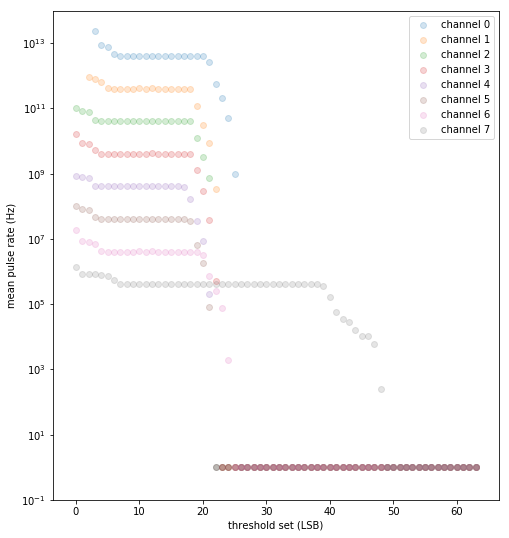

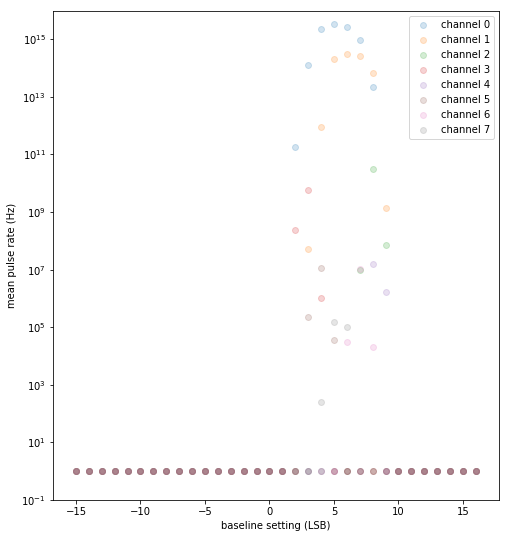

In [26]:
# staggerd plots:
    plt.rcParams["figure.figsize"] = (8,9)
    for i in range(0,8):
          nums = np.array(tsbl_scan_raw[i])*10**(8-i)+1
          plt.scatter(tsbl_range,nums,alpha=0.2,label = "channel {:d}".format(i))

          plt.legend()
          plt.xlabel("threshold set (LSB)")
          plt.ylabel("mean pulse rate (Hz)")
    plt.yscale('log') 
    plt.ylim(ymax = 1E14, ymin = 0.1)
    plt.show()

    plt.rcParams["figure.figsize"] = (8,9)
    for i in range(0,8):
         nums = np.array(noise_scan_raw[i])*10**(8-i)+1
         plt.scatter(noise_range, nums,alpha=0.2,label = "channel {:d}".format(i))

         plt.legend()
         plt.xlabel("baseline setting (LSB)")
         plt.ylabel("mean pulse rate (Hz)")

    plt.yscale('log') 
    plt.ylim(ymax = 1E16, ymin = 0.1)
    plt.show()


 baseline scans


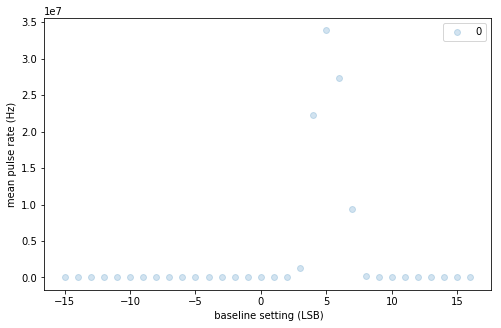

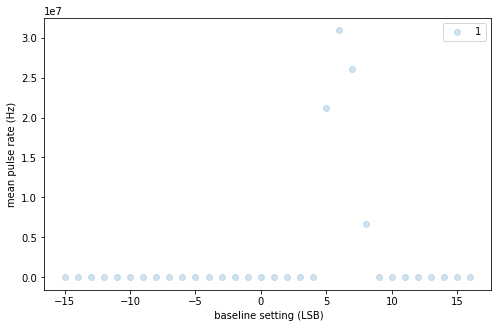

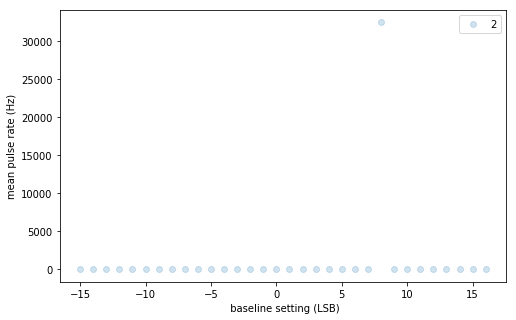

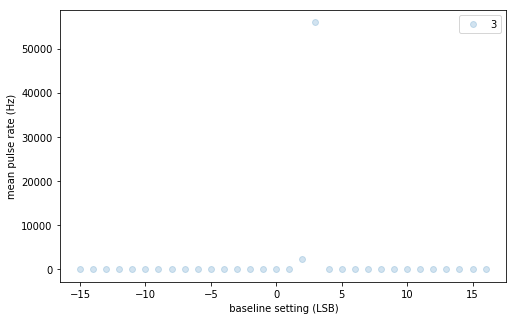

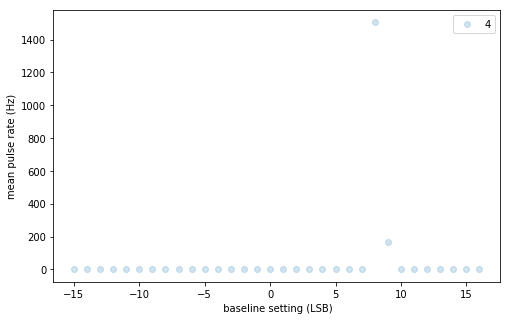

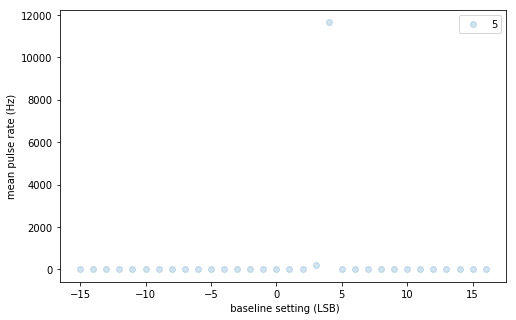

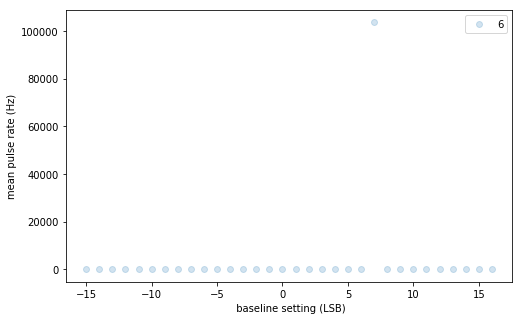

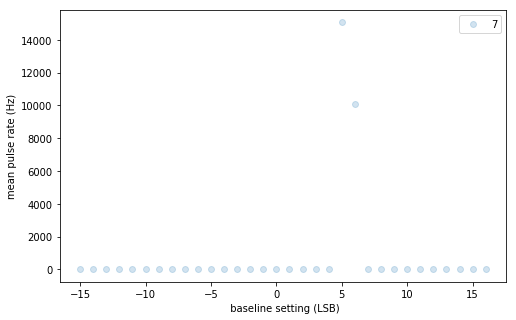

In [27]:
#baselines plot:
print("\n baseline scans")
plt.rcParams["figure.figsize"] = (8,5)

for i in range(0,8):
       plt.scatter(noise_range,noise_scan_raw[i],alpha=0.2,label = "{:d}".format(i))

       plt.legend()
       plt.xlabel("  baseline setting (LSB) ")
       plt.ylabel("mean pulse rate (Hz)")
       #plt.yscale('log') 
       plt.show()
    



 threshold scans


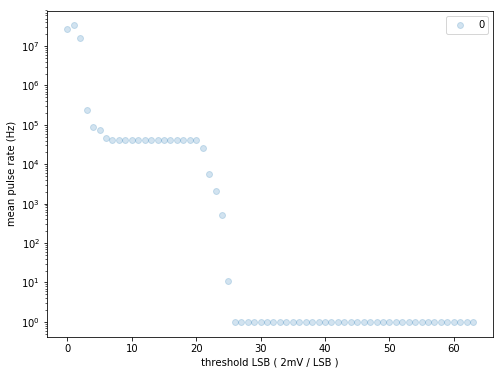

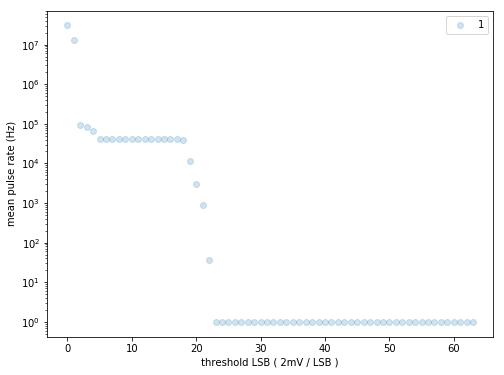

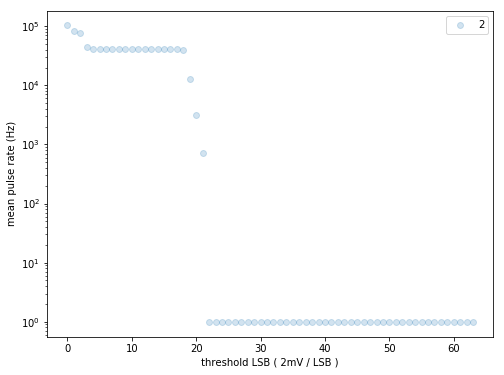

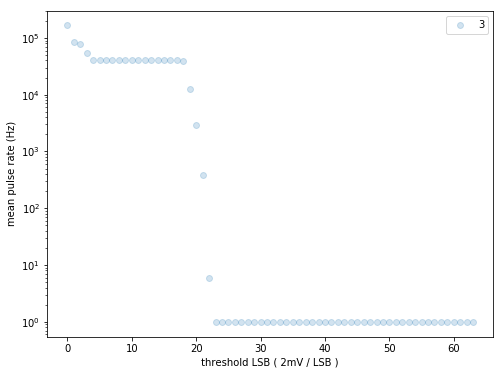

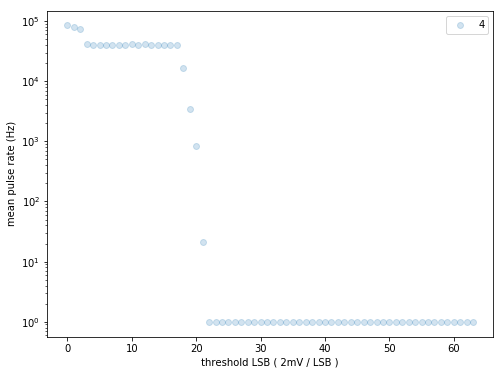

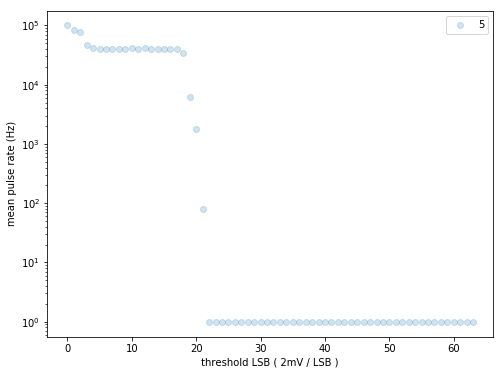

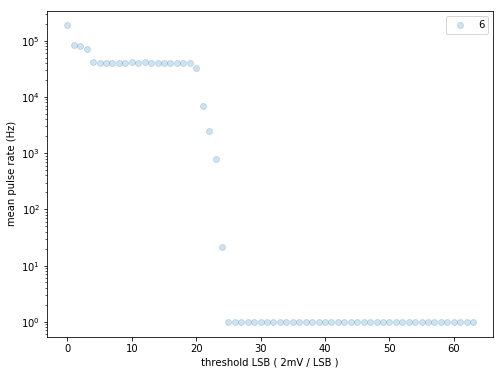

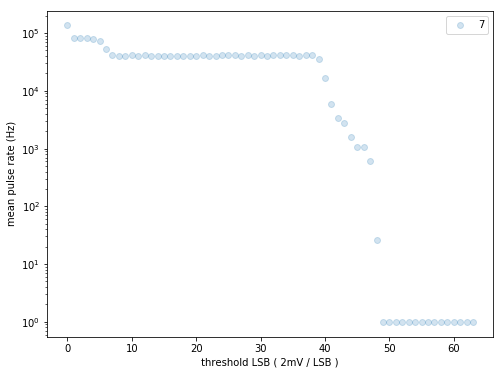

In [28]:
    
# threshold scan plots:
print("\n threshold scans")
plt.rcParams["figure.figsize"] = (8,6)
for i in range(0,8): 
      nums = np.array(tsbl_scan_raw[i])+1
      plt.scatter(tsbl_range,nums,alpha=0.2,label = "{:d}".format(i))

      plt.legend()
      plt.xlabel(" threshold LSB ( 2mV / LSB ) ")
      plt.ylabel("mean pulse rate (Hz)")
      plt.yscale('log') 
      plt.show()